<center>
<h1> Algorithmic Trading </h1>
<h2> Buy Low Sell High: a High Frequency Trading Perspective </h1>
<h2> MMMEF </h2>
<h3> Youssef BULAHIA - Ouijdane ABCHIR </h3>

The aim of this notebook is to implement a simulation of a High Frequency Trading strategy presented in the paper "Buy Low Sell High: a High Frequency Trading Perspective" by Alvaro Cartea, Sebastian Jaimungal, Jason Ricci.

In this High Frequency trading (HF) strategy, the HF trader uses her superior speed to process information and to post limit sell and buy orders.
A unique characteristic to HF trading is that the strategies are designed to hold close to
no inventories over very short periods of time (seconds, minutes, or at most one day) to avoid both
exposure to markets after close and to post collateral overnight. Thus, profits are made by turning
over positions very quickly to make a very small margin per roundtrip transaction (buy followed by
a sell or vice-versa), but repeating it as many times as possible during each trading day.

we will apply the simulation study of the HF strategy that is presented in the paper, where market orders, buy and sell,are generated over a period of 5 minutes (maturity).

The main purpose at the end, is simulating the PnL distribution of the High Frequency strategy in term of different parameters.

We will start by importing all the packages used in the following steps of the simulation.

In [522]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.special import lambertw
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

First of all, we will initiate all the parameters that we need to develop this strategy.
We assume that news does not arrive during the simulation and assume the following values for the parameters :  

In [523]:
# Mean reversion of intensity of MO arrivals
β = 60
# Speed and level of mean reversion of intensity of MO arrivals
theta = 1 
η = 40
# Jumps in λt upon the arrival of influential MOs
ν = 10
ξ = 10
# Speed and level of mean reversion for the κt process
ϑ = 50 
η_κ = 10
# Jumps in κt upon the arrival of influential MOs
ν_κ = 25
# Long-term component of the drift of themidprice
υ = 0
# Volatility of diffusion component of the midprice
sigma = 0.01 
ζ = 2
# Speed of mean reversion and volatility of diffusion component of αt process
sigma_α = 0.01 
# MOs are generated over a period of 5 minutes : 300 secondes. 
maturity = 300

Here, we will define the main function of the HFT strategy.

The stochastic drift $α_t$, fill probabilites $κ_t$, market orders activities $λ_t$, midprices S, cash X, PnL, and optimal postings $δ_t$ are all calculated using the assumptions and propositions in the paper that provides many explicit expressions for implementation.

We note that the strategy is under an exponential fill rate, which means that $h_t = e^{-κ_t δ_t}$.

In [524]:
def HF_Strategy(n, ρ, ε, c_trans, alpha, phi):
    PnL = []
    for i in range(0,n):
        t_next = 0
        t = [0]
        λ_plus = [1]
        λ_minus = [0.75]
        λ_plus_updated = [1]
        λ_minus_updated = [0.75]
        α = [0]
        α_updated = [0]
        #Initial transaction cost in $
        S = [100]
        X = [0]
        q = [0]
        κ_plus = [2]
        κ_minus = [1]
        δ_plus = [1]
        δ_minus = [0.5]
        while(t_next < maturity):
            #step 1
            λ = λ_plus[-1] + λ_minus[-1]
            u1 = np.random.uniform(0,1)
            ς = (1/(2*theta)) * (λ - 2*theta + β * log(u1))
            τ = float(lambertw((1/(2*theta))* (λ - 2*theta) * exp(ς)))
            T = (1/β) * (τ - ς)
            t_next = t[-1] + T
            t.append(t_next)
            #step 2 and 3
            λ_plus.append(theta + (λ_plus[-1] - theta)*np.exp(-β*T))
            λ_minus.append(theta + (λ_minus[-1] - theta)*np.exp(-β*T))
            p_buy = (theta +(λ_plus[-2] - theta)*np.exp(-β*T))/(2*theta+ (λ_plus[-2] + λ_minus[-2] - 2*theta)*np.exp(-β*T))
            u2 = np.random.uniform(0,1)
            if p_buy > u2:
                B = 1
            else :
                B = -1
            #step 4
            U = np.random.normal()
            V = np.random.normal()
            cov1_2 = (sigma**2/(2*(ζ**2)))*(1 - 2*np.exp(-ζ*T) + np.exp(-2*ζ*T))
            vol1 = (sigma**2/(ζ**2))*(T - (2/ζ)*(1 - np.exp(-ζ*T)) + (1/2*ζ)*(1 - np.exp(-2*ζ*T)))
            vol2 = (sigma**2/(2*ζ))*(1 - np.exp(-2*ζ*T))
            corr = cov1_2/np.sqrt(vol1*vol2)
            W = U*corr + np.sqrt(1-corr**2)*V
            Z1 = U*np.sqrt(vol1)
            Z2 = W*np.sqrt(vol2)
            Z = np.random.normal()
            if alpha:
                α.append(α[-1]*np.exp(-ζ*T)+Z2)
                S.append(S[-1]+(α[-2]/ζ)*(1 - np.exp(-ζ*T)) + Z1 + sigma*np.sqrt(T)*Z)
            else:
                S.append(S[-1]+(α[-1]/ζ)*(1 - np.exp(-ζ*T)) + Z1 + sigma*np.sqrt(T)*Z)
            q.append(q[-1] - B)
            #step 5 and 6
            u3 = np.random.uniform(0,1)
            if u3<ρ:
                H = 1
            else:
                H = 0
            λ_plus_updated.append(theta + (λ_plus_updated[-1] - theta)*np.exp(-β*T)+ ((1 + B)*ν + (1 - B)*η)*(1/2)*H)
            λ_minus_updated.append(theta + (λ_minus_updated[-1] - theta)*np.exp(-β*T)+ ((1 - B)*ν + (1 + B)*η)*(1/2)*H)
            κ_plus.append(ϑ  + (κ_plus[-1] - ϑ)*np.exp(-ξ*T)+ ((1 + B)*ν_κ + (1 - B)*η_κ)*(1/2)*H)
            κ_minus.append(ϑ + (κ_minus[-1] - ϑ)*np.exp(-ξ*T)+ ((1 - B)*ν_κ + (1 + B)*η_κ)*(1/2)*H)
            α_updated.append(α[-1] + (1/2)*((1+B)*np.random.exponential(ε) - (1-B)*np.random.exponential(ε)))
            β_ = β - ρ*(ν - η)
            b_phi = 2*np.exp(-1)*(λ_plus_updated[-1] - λ_minus_updated[-1])*((1/β_)*T - (1 - np.exp(-β_*T))/β_**2)
            b_plus = (1-ρ)*b_phi + ρ*2*np.exp(-1)*(λ_plus_updated[-1] - λ_minus_updated[-1] + B*(ν - η))*((1/β_)*T - (1 - np.exp(-β_*T))/β_**2)
            b_minus = (1-ρ)*b_phi + ρ*2*np.exp(-1)*(λ_plus_updated[-1] - λ_minus_updated[-1] + B*(η - ν))*((1/β_)*T - (1 - np.exp(-β_*T))/β_**2)
            e_ = (1/β_)*((1 - np.exp(-β_*T)) - (1/ζ)*(np.exp(-ζ*T) - np.exp(-β_*T)))
            e = ((ρ*ε)/ζ)*(λ_plus_updated[-1] - λ_minus_updated[-1])*e_ + (α_updated[-1]/ζ)*(1 - np.exp(-ζ*T))
            e_plus = (1-ρ)*e + ρ*((ρ*ε)/ζ)*(λ_plus_updated[-1] - λ_minus_updated[-1] + B*(ν - η))*e_ + ((α_updated[-1] + ε)/ζ)*(1 - np.exp(-ζ*T))
            e_minus = (1-ρ)*e + ρ*((ρ*ε)/ζ)*(λ_plus_updated[-1] - λ_minus_updated[-1] + B*(η - ν))*e_ + ((α_updated[-1] - ε)/ζ)*(1 - np.exp(-ζ*T))
            δ_plus.append(max((1/κ_plus[-2]) + (1/(2 - (1/κ_plus[-2])**2))*(phi*((1-2*q[-1])*T + b_plus) + e_plus),0))
            δ_minus.append(max((1/κ_minus[-2]) + (1/(2 - (1/κ_minus[-2])**2))*(phi*((1-2*q[-1])*T + b_minus) + e_minus),0))
            X.append(X[-1]+B*S[-1] + max(δ_plus[-1], 0))
        PnL.append(X[-1] + q[-1]*S[-1]*(1 - c_trans*np.sign(q[-1])))
    return t, λ_plus_updated, λ_minus_updated, κ_plus, κ_minus, α_updated, S, X, δ_plus, δ_minus, PnL

<h3> Case : φ = 0.00001, alpha = 1 (stochastic drift), ε = 0.04 and c_trans = 0.0001 (1 BP) </h3> 

We want to compare the performance of the HF market making strategy by varying the quality of the information that the HFT is able to employ when calculating the optimal postings. 

We will present a graphical comparison between the different results while varying ρ.

We will start by ploting the stochastic drift of the price.

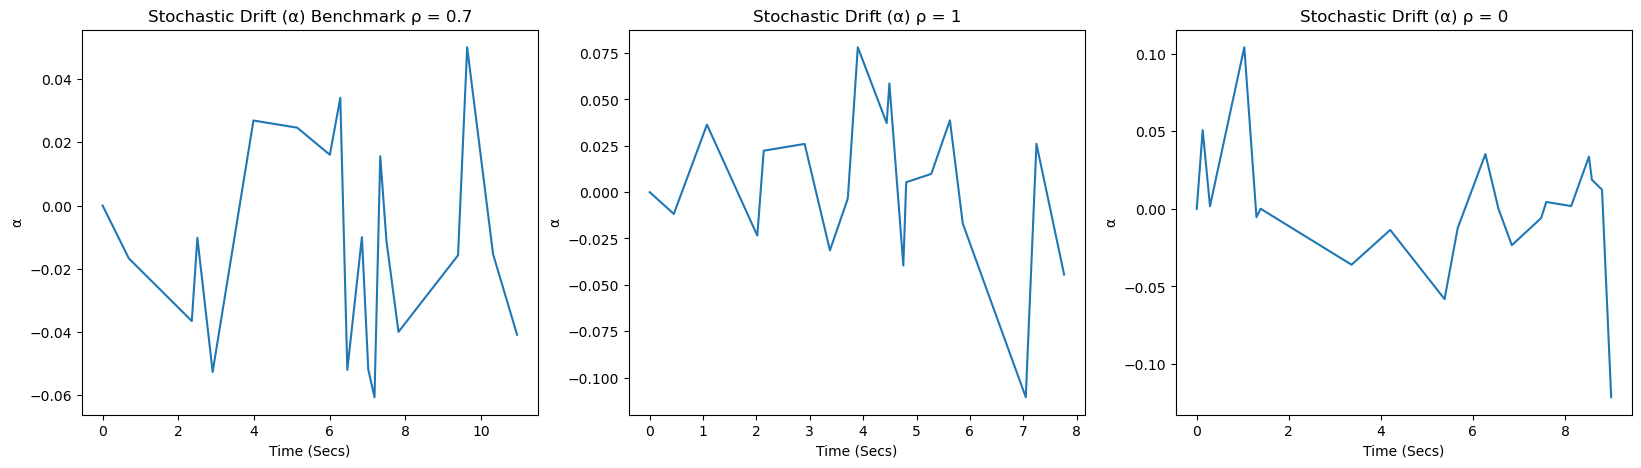

In [528]:
# Numebr of simulations
n = 1
# Probability of the MO being influential
ρ = [0.7, 1, 0]
# Others parameters
phi = [10**(-5), 2*(10**(-5)), 4*(10**(-5))]
ε = [0.04, 0.02]
# Liquidation cost :
c_trans = [0.0001, 0.001] # 1 BP / 10 BP
# αt process is stochastic
alpha = [0, 1]
ρ = [0.7, 1, 0]
model = ['Benchmark ρ = 0.7', 'ρ = 1', 'ρ = 0']
# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range (3):
    # We take a stochastic α 
    Strategy = HF_Strategy(n, ρ[j], ε[0], c_trans[0], alpha[1], phi[0])
    t = Strategy[0]
    α_updated = Strategy[5]
    axs[j].plot(t[0:20], α_updated[0:20])
    axs[j].set_title('Stochastic Drift (α) ' + model[j])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('α')

Then, we will plot the market order activities $\lambda^+$ and $\lambda^-$.

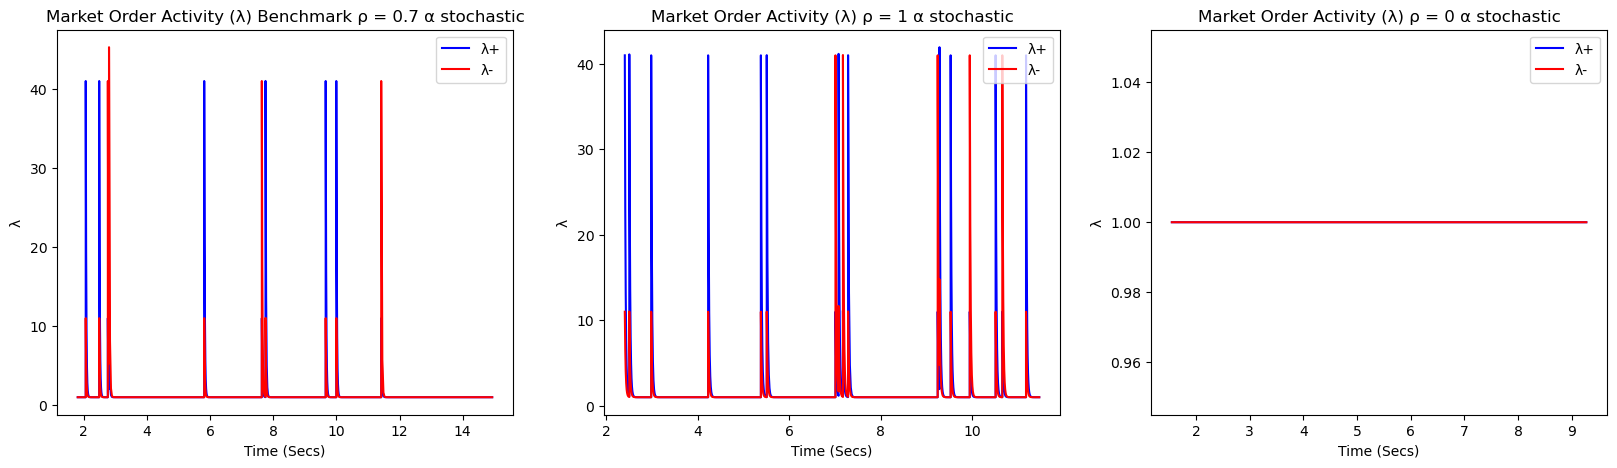

In [529]:
# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
α_stoch = ["α zero", "α stochastic"]
for j in range (3):
    # We take a stochastic α
    Strategy = HF_Strategy(n, ρ[j], ε[0], c_trans[0], alpha[1], phi[0])
    t = Strategy[0]
    λ_plus_updated = Strategy[1]
    λ_minus_updated = Strategy[2]
    x_values = []
    λplus_values = []
    λminus_values = []
    for i in range(3, len(t[0:20])):
        x = np.linspace(t[i], t[i+1], 100) 
        λplus = theta + (λ_plus_updated[i] - theta) * np.exp(-β * (x - t[i]))
        λminus = theta + (λ_minus_updated[i] - theta) * np.exp(-β * (x - t[i]))
        x_values.extend(x)
        λplus_values.extend(λplus)
        λminus_values.extend(λminus)
    axs[j].plot(x_values, λplus_values, color='blue', label='λ+')
    axs[j].plot(x_values, λminus_values, color='red',label='λ-')
    axs[j].set_title('Market Order Activity (λ) ' + model[j] + " " + α_stoch[1])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('λ')
    axs[j].legend()

We will plot the fill probabilities $\kappa^+$ and $\kappa^-$.

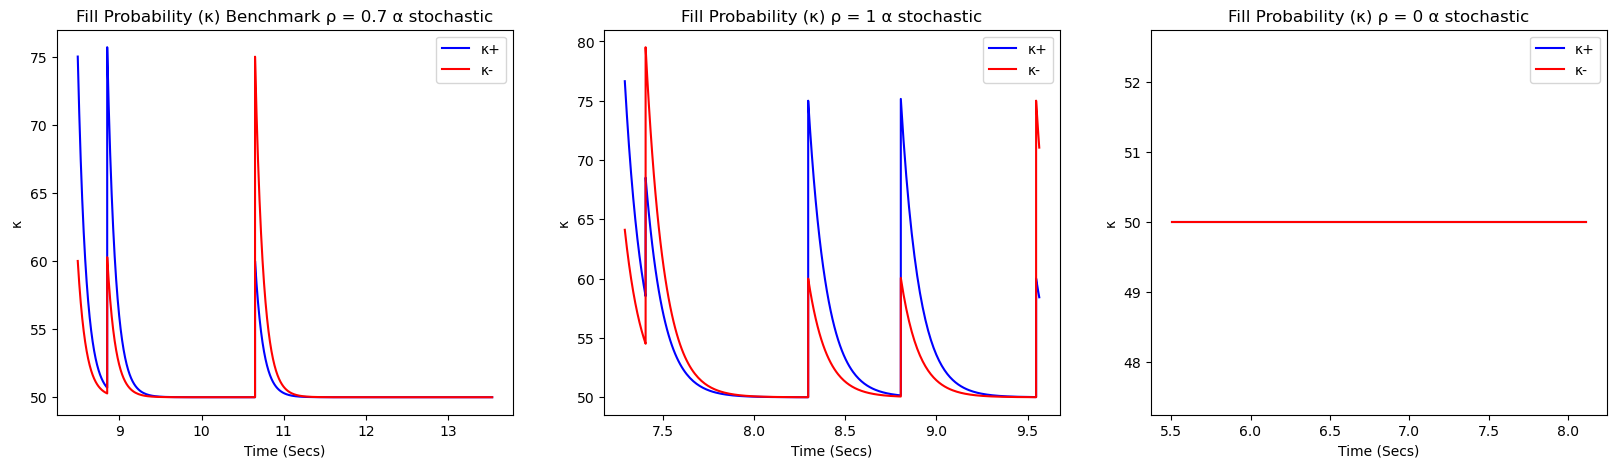

In [530]:
# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range (3):
    # We take a stochastic α 
    Strategy = HF_Strategy(n, ρ[j], ε[0], c_trans[0], alpha[1], phi[0])
    t = Strategy[0]
    κ_plus = Strategy[3]
    κ_minus = Strategy[4]
    x_values = []
    κplus_values = []
    κminus_values = []
    for i in range(15, len(t[0:20])):
        x = np.linspace(t[i], t[i+1], 100) 
        κplus = ϑ + (κ_plus[i] - ϑ) * np.exp(-η_κ * (x - t[i]))
        κminus = ϑ + (κ_minus[i] - ϑ) * np.exp(-η_κ * (x - t[i]))
        x_values.extend(x)
        κplus_values.extend(κplus)
        κminus_values.extend(κminus)
    axs[j].plot(x_values, κplus_values, color='blue', label='κ+')
    axs[j].plot(x_values, κminus_values, color='red',label='κ-')
    axs[j].set_title('Fill Probability (κ) ' + model[j] + " " + α_stoch[1])
    axs[j].set_xlabel('Time (Secs)')
    axs[j].set_ylabel('κ')
    axs[j].legend()

We have ploted for the three models a sample path of the traders interpretation of the stochastic drift, market order activity, and fill probability parameter. 
The benchmark model has the correct data generating path, while the others under- or over-estimate the role of trade arrivals.

We deduce that as the dynamics of $α_t$ show over approximately a 5 seconds window. We see that for this particular time interval of the simulation, αt is sometimes negative, and every time an influential order arrives the stochastic drift jumps up (buy market order) or down(sell market order) by a random amount which is drawn from an exponential distribution with mean ε = 0.04.

We will visualize the price, the limit buy and the limit sell in the case of stochastic and constant $α_t$.

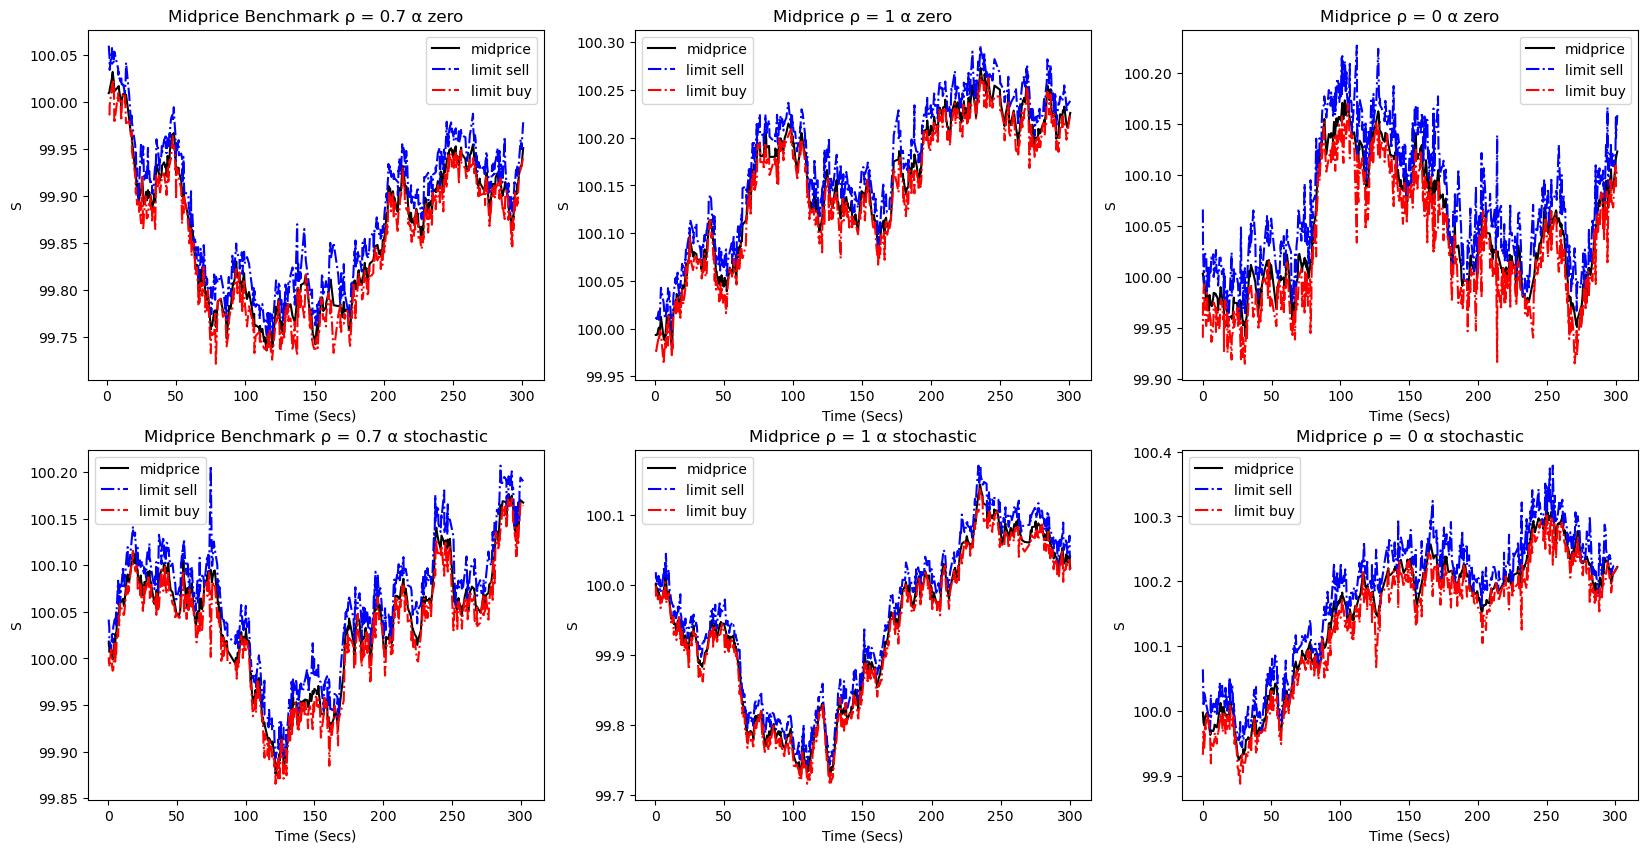

In [539]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for l in range(2):
    for j in range (3):
        Strategy = HF_Strategy(n, ρ[j], ε[0], c_trans[0], alpha[l], phi[0])
        t = Strategy[0]
        S = Strategy[6]
        δ_plus = Strategy[8]
        δ_minus = Strategy[9]
        axs[l][j].plot(t[2:], S[2:], 'black', label = 'midprice')
        axs[l][j].plot(t[2:], np.add(S[2:], δ_plus[2:]).tolist(), 'b', label = 'limit sell', linestyle = '-.')
        axs[l][j].plot(t[2:], list(map(lambda a, b: a - b, S[2:], δ_minus[2:])), 'r', label = 'limit buy', linestyle = '-.')
        axs[l][j].set_title('Midprice ' + model[j] + " " + α_stoch[l])
        axs[l][j].set_xlabel('Time (Secs)')
        axs[l][j].set_ylabel('S')
        axs[l][j].legend()

We will plot the agent's cash in the case of stochastic and constant $α_t$.

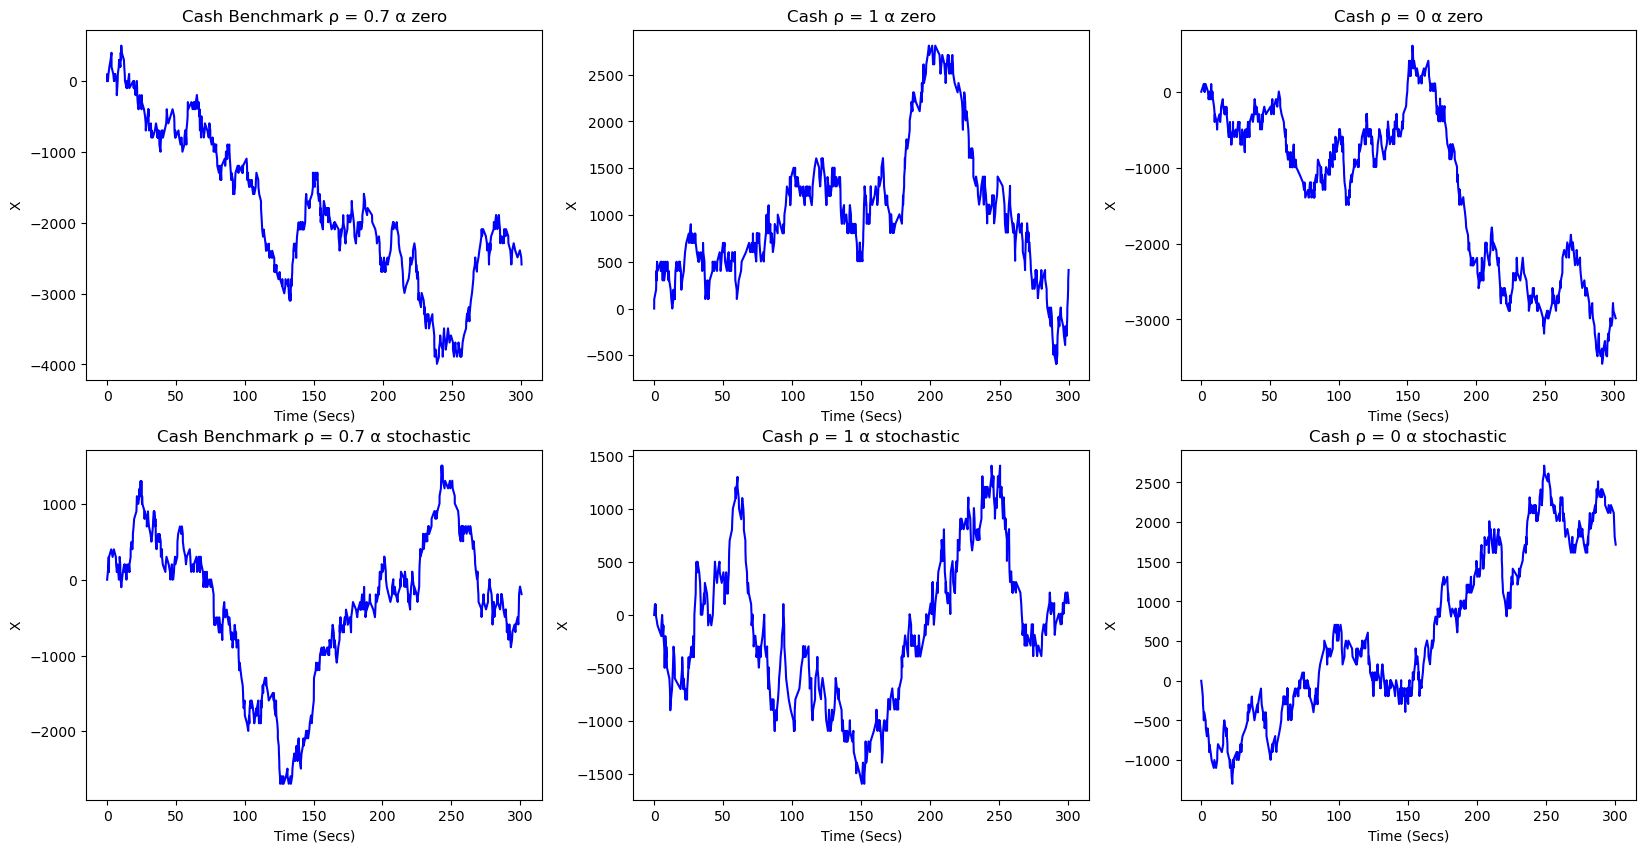

In [537]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for l in range(2):
    for j in range (3):
        Strategy = HF_Strategy(n, ρ[j], ε[0], c_trans[0], alpha[l], phi[0])
        t = Strategy[0]
        X = Strategy[7]
        axs[l][j].plot(t, X, 'b')
        axs[l][j].set_title('Cash ' + model[j] + " " + α_stoch[l])
        axs[l][j].set_xlabel('Time (Secs)')
        axs[l][j].set_ylabel('X')

We noticed that when influential trades arrive, the activity of both buy and sell orders increase
but by differing amounts, the FP parameters also jump, and both decay to their long-run levels. Circles indicate the arrival of an influential market order, while squares indicate the arrival of non-influential trades. Open symbols indicate those market orders which do not fill the traders limit orders, while filled in symbols indicate those market orders which do fill the traders limit orders.

Finally, here is the evolution of the PnL for 5000 simulations :

/var/folders/ct/1jcf3_210l7761kmjs9wb7km0000gn/T/ipykernel_68221/2827365528.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  τ = float(lambertw((1/(2*theta))* (λ - 2*theta) * exp(ς)))


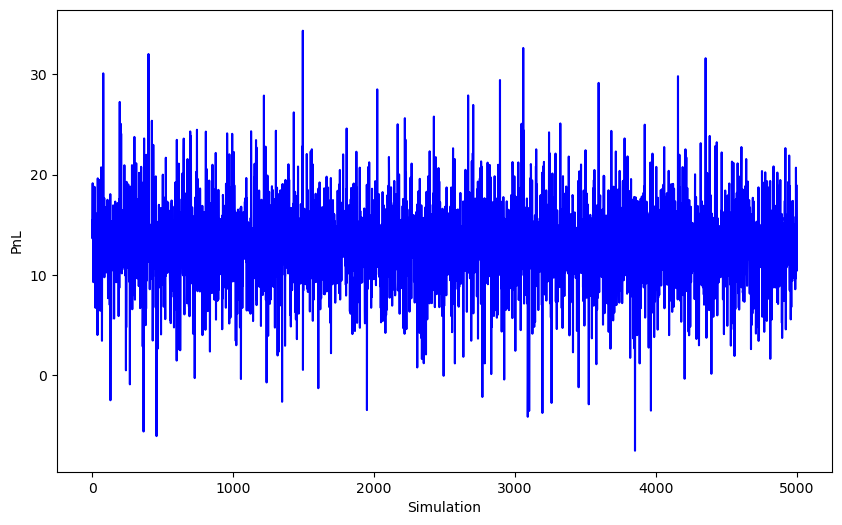

In [482]:
Strategy = HF_Strategy(5000, ρ[0], ε[0], c_trans[0], alpha[1], phi[0])
PnL = Strategy[-1]
plt.figure(figsize=(10, 6))
plt.plot(PnL, 'b')
plt.xlabel("Simulation")
plt.ylabel("PnL")
plt.show()

<h3> Comparison : ε = 0.04 and c_trans = 1 BP </h3> 

In this section, we will vary ρ, φ, and the dynamics of alpha (constant or stochastic).

We will generate the mean and standard deviation of the PnL in each case.

To generate the PnL we assume that the final inventory is liquidated at the midprice with different
transactions costs per share : 1 basis point in the first case.

In each simulation the process is repeated 5, 000 times to obtain the PnLs of the various strategies.

In [511]:
for j in range(2) :
    print("In the case of " + α_stoch[j] + ", 1 BP and ε = 0.04")
    for phi_ in phi:
        df = pd.DataFrame()
        for i in range(3):
            mean_std = []
            Strategy = HF_Strategy(5000, ρ[i], ε[0], c_trans[0], alpha[j], phi_)
            mean_std.extend([np.mean(Strategy[-1]), np.std(Strategy[-1])])
            df[model[i]] = mean_std 
            df.index = ["mean", "std"]
            df.index.name = "φ = " + str(phi_)
        display(df)

In the case of α zero and 1 BP


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 1e-05,,,
mean,13.075337,11.938404,15.774361
std,3.606927,3.458322,3.508735


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 2e-05,,,
mean,12.997403,11.997777,15.72475
std,3.449598,3.490777,3.53429


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 4e-05,,,
mean,13.032413,11.954508,15.681490
std,3.443386,3.399650,3.471911


In the case of α stochastic and 1 BP


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 1e-05,,,
mean,12.969230,12.081863,15.768861
std,3.830751,3.709697,3.793177


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 2e-05,,,
mean,12.989928,11.985326,15.647055
std,3.700793,3.751669,3.810374


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 4e-05,,,
mean,12.954425,12.019643,15.749007
std,3.749674,3.770620,3.764480


The tables clearly shows that market making is more profitable if the HFTs incorporate in their optimal strategies predictions of short-term-alpha – this is true even if the HFTs incorrectly specify the short-term-alpha parameters.

When we run run simulations with different parameter choices, we noticeed that the benchmark HFT always performs better than the other HFTs.

<h3> Comparison : ε = 0.04 and c_trans = 10 BP </h3> 

Here, the comparison is similar to the one above, except that we fix c_trans = 10 BP.

In [520]:
for j in range(2) :
    print("In the case of " + α_stoch[j] + ", 10 BP and ε = 0.04")
    for phi_ in phi:
        df = pd.DataFrame()
        for i in range(3):
            mean_std = []
            Strategy = HF_Strategy(5000, ρ[i], ε[0], c_trans[1], alpha[j], phi_)
            mean_std.extend([np.mean(Strategy[-1]), np.std(Strategy[-1])])
            df[model[i]] = mean_std 
            df.index = ["mean", "std"]
            df.index.name = "φ = " + str(phi_)
        display(df)

In the case of α zero, 10 BP and ε = 0.04


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 1e-05,,,
mean,11.206408,10.207464,13.973648
std,3.901678,3.724108,3.850317


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 2e-05,,,
mean,11.311095,10.208373,13.940904
std,3.677419,3.816742,3.848833


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 4e-05,,,
mean,11.265981,10.140119,14.096300
std,3.739465,3.769992,3.806295


In the case of α stochastic, 10 BP and ε = 0.04


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 1e-05,,,
mean,11.233907,10.080235,14.036819
std,3.927668,3.930320,4.095103


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 2e-05,,,
mean,11.214718,10.314090,13.988882
std,3.925618,3.959283,4.086665


,Benchmark ρ = 0.7,ρ = 1,ρ = 0
φ = 4e-05,,,
mean,11.295377,10.265561,13.840696
std,4.034936,4.066353,4.025811


We noticed the same remark as before.

<h3> Conclusion </h3> 

We devised an HF trading strategy focusing on the HFT's speed advantage, distinguishing influential and non-influential market orders. 

We conclude that our model incorporates short-term alpha prediction, optimizing limit order placement based on an optimal control framework. Simulations reveal profitable outcomes for HFTs leveraging short-term price deviations. We acknowledge a gap in our model regarding optimal market order execution timing. Additionally, our model captures the self-exciting nature of market manipulation, though further analysis is needed.